<a href="https://colab.research.google.com/github/FarazTheAnalyst/Python-Code/blob/main/Python_MachineLearning_Projects/Salary_Prediction_Train_Save_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [41]:
# Load data (original from Kaggle: https://www.kaggle.com/datasets/mohithsairamreddy/salary-data)

from google.colab import files
uploaded = files.upload()

Saving Salary_Data.csv to Salary_Data (2).csv


In [42]:
df = pd.read_csv("/content/Salary_Data.csv")
df

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0
...,...,...,...,...,...,...
6699,49.0,Female,PhD,Director of Marketing,20.0,200000.0
6700,32.0,Male,High School,Sales Associate,3.0,50000.0
6701,30.0,Female,Bachelor's Degree,Financial Manager,4.0,55000.0
6702,46.0,Male,Master's Degree,Marketing Manager,14.0,140000.0


In [43]:
df.isna().sum()

,0
Age,2
Gender,2
Education Level,3
Job Title,2
Years of Experience,3
Salary,5


Data cleaning

In [44]:
def clean_data(df):
  #handle missing values
  df.dropna()

  #remove outliers
  q1 = df["Salary"].quantile(0.25)
  q3 = df["Salary"].quantile(0.75)
  iqr = q3 - q1
  df = df[(df["Salary"] >= q1 - 1.5*iqr) & (df["Salary"] <= q3 + 1.5*iqr)]

  #convert Experience to numeric
  df = df.copy()
  df['Years of Experience'] = df['Years of Experience'].astype(str).str.extract(r'(\d+)').astype(float)

  return df


In [45]:
df_clean = clean_data(df)
df_clean.to_csv("salary_data_cleaned.csv", index=False)

In [46]:
#columns consistent
df_clean.columns = df_clean.columns.str.replace(" ", "_")
df_clean.columns

Index(['Age', 'Gender', 'Education_Level', 'Job_Title', 'Years_of_Experience',
       'Salary'],
      dtype='object')

In [47]:
#Prepare features and Target
X = df_clean[["Job_Title", "Years_of_Experience", "Education_Level", "Gender"]]
y = df_clean["Salary"]

In [48]:
#Preprocessing
categorical_features = ['Job_Title', 'Education_Level', 'Gender']
numeric_features = ["Years_of_Experience"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
         ])

In [49]:
preprocessor



ColumnTransformer(transformers=[('num', 'passthrough', ['Years_of_Experience']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['Job_Title', 'Education_Level', 'Gender'])])

In [50]:
#Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [51]:
#Model comparision function
def compare_models():
    models = {
        "Linear Regression": LinearRegression(),
        "Decision Tree": DecisionTreeRegressor(random_state=42),
        "Random Forest": RandomForestRegressor(random_state=42)
    }

    results = []

    for name, model in models.items():
        pipe = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("model", model)
        ])

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        results.append({
            "Model": name,
            "Mae": mae,
            "R2 score": r2
        })

        # Plot feature importance for random forest
        if name == "Random Forest":
            ohe = pipe.named_steps["preprocessor"].named_transformers_["cat"]
            cat_features = ohe.get_feature_names_out(categorical_features)
            all_features = np.concatenate([numeric_features, cat_features])

            # plot feature importance
            importance = pipe.named_steps["model"].feature_importances_
            indices = np.argsort(importance)[-10:]

            plt.figure(figsize=(10, 6))
            plt.title("Top 10 important features")
            plt.barh(range(len(indices)), importance[indices], color="b", align="center")
            plt.yticks(range(len(indices)), [all_features[i] for i in indices])
            plt.xlabel("Relative importance")
            plt.tight_layout()
            plt.savefig("/content/feature_importance.png")
            plt.show()

    return pd.DataFrame(results)

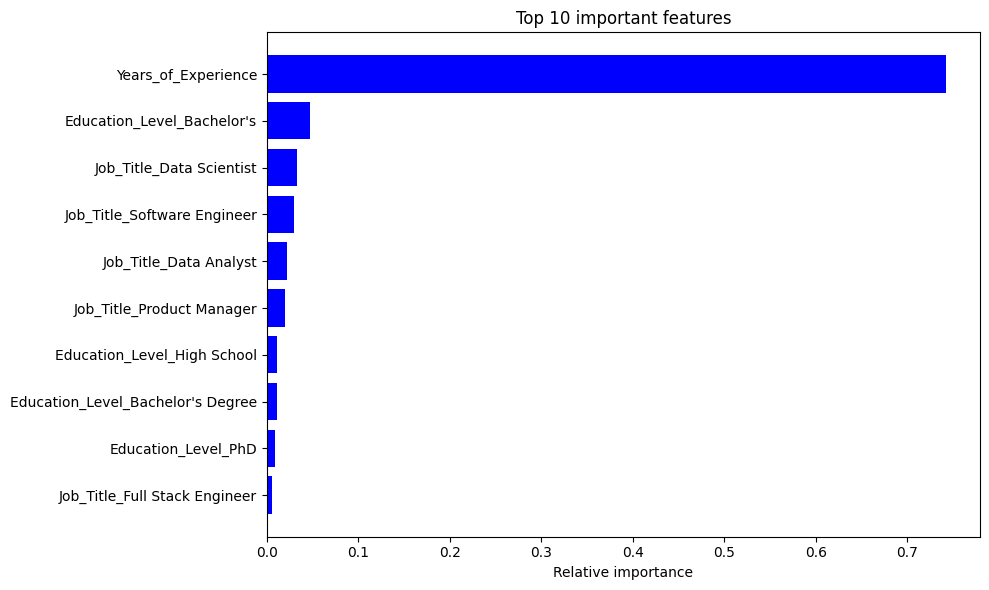


Models Camparision results
               Model           Mae  R2 score
0  Linear Regression  13282.125923  0.878114
1      Decision Tree   3700.800359  0.972690
2      Random Forest   3708.224067  0.976160


In [52]:

#compare models and show results
results_df = compare_models()
print("\nModels Camparision results")
print(results_df)

In [53]:
#Train and save the best model
best_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(n_estimators=100, random_state=42))
])

best_model.fit(X_train, y_train)

from google.colab import drive
drive.mount('/content/drive')

os.makedirs("/content/drive/MyDrive/MlModels", exist_ok=True)
joblib.dump(best_model, "/content/drive/MyDrive/MlModels/salary_predictor.pkl")
print("\nModel training complete, best model(Random Forest) saved.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Model training complete, best model(Random Forest) saved.
